# MiniProject1


Set the imports and set the random seed

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace # to help for debugging

# Initialize the random number generator by setting the seed
np.random.seed(1234) 

## Task 1: Acquire, preprocess, and analyze the data

Import the data from the hepatitis datasets and clear rows containing unknown results.

In [ ]:
data_hepatitis = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/hepatitis/hepatitis.data", 
                names = ["CLASS", "AGE", "SEX", "STEROID", "ANTIVIRALS", "FATIGUE", "MALAISE", "ANOREXIA",
                        "LIVER BIG", "LIVER FIRM", "SPLEEN PALPABLE", "SPIDERS", "ASCITES", "VARICES",
                        "BILIRUBIN", "ALK PHOSPHATE", "SGOT", "ALBUMIN", "PROTIME", "HISTOLOGY"])

# Remove all unnecessary data
for col in data_hepatitis.columns:
    data_hepatitis = data_hepatitis[data_hepatitis[col] != '?']

# Convert all data to integers to make it easier to work with
for col in data_hepatitis.columns:    
    data_hepatitis = data_hepatitis.apply(pd.to_numeric)

data_hepatitis

,CLASS,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER BIG,LIVER FIRM,SPLEEN PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY
5,2,34,1,2,2,2,2,2,2,2,2,2,2,2,0.9,95,28,4.0,75,1
10,2,39,1,1,1,2,2,2,1,1,2,2,2,2,1.3,78,30,4.4,85,1
11,2,32,1,2,1,1,2,2,2,1,2,1,2,2,1.0,59,249,3.7,54,1
12,2,41,1,2,1,1,2,2,2,1,2,2,2,2,0.9,81,60,3.9,52,1
13,2,30,1,2,2,1,2,2,2,1,2,2,2,2,2.2,57,144,4.9,78,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2,45,1,2,1,2,2,2,2,2,2,2,2,2,1.3,85,44,4.2,85,2
143,1,49,1,1,2,1,1,2,2,2,1,1,2,2,1.4,85,70,3.5,35,2
145,2,31,1,1,2,1,2,2,2,2,2,2,2,2,1.2,75,173,4.2,54,2
153,2,53,2,1,2,1,2,2,2,2,1,1,2,1,1.5,81,19,4.1,48,2


Import data from Diabetic Retinopathy Debrecen

In [ ]:
data_diabetic = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00329/messidor_features.arff", 
                            names = ["QUALITY ASSESSMENTS", "PRE-SCREENING", "MA DETECTION1", "MA DETECTION2", "MA DETECTION3", "MA DETECTION4",
                                     "MA DETECTION5", "MA DETECTION6", "EXUDATE DETECTION1", "EXUDATE DETECTION2", "EXUDATE DETECTION3",
                                     "EXUDATE DETECTION4", "EXUDATE DETECTION5", "EXUDATE DETECTION6", "EXUDATE DETECTION7", "EXUDATE DETECTION8",
                                     "EUCLIEAN DISTANCE", "DIAMETER", "AM/FM CLASSIFICATION", "CLASS LABEL"],
                            skiprows=[i for i in range(0,24)])

# Remove invalid rows
for col in data_diabetic.columns:
    data_diabetic = data_diabetic[data_diabetic[col] != '?']

# Convert all data to integers to make it easier to work with
for col in data_diabetic.columns:    
    data_diabetic = data_diabetic.apply(pd.to_numeric)

# Replace 0 and 1 by 1 and 2 for consistency with the hepatitis dataset
data_diabetic = data_diabetic.replace(to_replace={"CLASS LABEL": {0: 1, 1: 2}})

data_diabetic                              

,QUALITY ASSESSMENTS,PRE-SCREENING,MA DETECTION1,MA DETECTION2,MA DETECTION3,MA DETECTION4,MA DETECTION5,MA DETECTION6,EXUDATE DETECTION1,EXUDATE DETECTION2,EXUDATE DETECTION3,EXUDATE DETECTION4,EXUDATE DETECTION5,EXUDATE DETECTION6,EXUDATE DETECTION7,EXUDATE DETECTION8,EUCLIEAN DISTANCE,DIAMETER,AM/FM CLASSIFICATION,CLASS LABEL
0,1,1,22,22,22,19,18,14,49.895756,17.775994,5.270920,0.771761,0.018632,0.006864,0.003923,0.003923,0.486903,0.100025,1,1
1,1,1,24,24,22,18,16,13,57.709936,23.799994,3.325423,0.234185,0.003903,0.003903,0.003903,0.003903,0.520908,0.144414,0,1
2,1,1,62,60,59,54,47,33,55.831441,27.993933,12.687485,4.852282,1.393889,0.373252,0.041817,0.007744,0.530904,0.128548,0,2
3,1,1,55,53,53,50,43,31,40.467228,18.445954,9.118901,3.079428,0.840261,0.272434,0.007653,0.001531,0.483284,0.114790,0,1
4,1,1,44,44,44,41,39,27,18.026254,8.570709,0.410381,0.000000,0.000000,0.000000,0.000000,0.000000,0.475935,0.123572,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1146,1,1,34,34,34,33,31,24,6.071765,0.937472,0.031145,0.003115,0.000000,0.000000,0.000000,0.000000,0.537470,0.116795,0,1
1147,1,1,49,49,49,49,45,37,63.197145,27.377668,8.067688,0.979548,0.001552,0.000000,0.000000,0.000000,0.516733,0.124190,0,1
1148,1,0,49,48,48,45,43,33,30.461898,13.966980,1.763305,0.137858,0.011221,0.000000,0.000000,0.000000,0.560632,0.129843,0,1
1149,1,1,39,36,29,23,13,7,40.525739,12.604947,4.740919,1.077570,0.563518,0.326860,0.239568,0.174584,0.485972,0.106690,1,2


## Task 2: Implement the models

### K-Nearest Neighbour

In [ ]:
# KNN
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)

class KNN:

    def __init__(self, K=1, dist_fn= euclidean):
        self.dist_fn = dist_fn
        self.K = K
        return
    
    def fit(self, x, y):
        ''' Store the training data using this method as it is a lazy learner'''
        self.x = x
        self.y = y
        self.C = np.max(y) + 1
        return self
    
    def predict(self, x_test):
        ''' Makes a prediction using the stored training data and the test data given as argument'''
        num_test = x_test.shape[0]
        #calculate distance between the training & test samples and returns an array of shape [num_test, num_train]
        distances = self.dist_fn(self.x[None,:,:], x_test[:,None,:])
        #ith-row of knns stores the indices of k closest training samples to the ith-test sample 
        knns = np.zeros((num_test, self.K), dtype=int)
        #ith-row of y_prob has the probability distribution over C classes
        y_prob = np.zeros((num_test, self.C))
        for i in range(num_test):
            knns[i,:] = np.argsort(distances[i])[:self.K]
            y_prob[i,:] = np.bincount(self.y[knns[i,:]], minlength=self.C) #counts the number of instances of each class in the K-closest training samples
        #y_prob /= np.sum(y_prob, axis=-1, keepdims=True)
        #simply divide by K to get a probability distribution
        y_prob /= self.K
        return y_prob, knns

### Decision Tree

We first define the Node class that will be used in our binary tree.

In [ ]:
class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices                    #stores the data indices which are in the region defined by this node
        self.left = None                                    #stores the left child of the node 
        self.right = None                                   #stores the right child of the node
        self.split_feature = None                           #the feature for split at this node
        self.split_value = None                             #the value of the feature for split at this node
        if parent:
            self.depth = parent.depth + 1                   #obtain the dept of the node by adding one to dept of the parent 
            self.num_classes = parent.num_classes           #copies the num classes from the parent 
            self.data = parent.data                         #copies the data from the parent
            self.labels = parent.labels                     #copies the labels from the parent
            class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes) #this is counting frequency of different labels in the region defined by this node
            self.class_prob = class_prob / np.sum(class_prob)  #stores the class probability for the node
            #note that we'll use the class probabilites of the leaf nodes for making predictions after the tree is built


We define different cost functions that will be used to find the splits that yield the lowest cost.

In [ ]:
#computes misclassification cost by subtracting the maximum probability of any class
def cost_misclassification(labels):
    counts = np.bincount(labels) 
    class_probs = counts / np.sum(counts)
    #you could compress both the steps above by doing class_probs = np.bincount(labels) / len(labels)
    return 1 - np.max(class_probs)

#computes entropy of the labels by computing the class probabilities
def cost_entropy(labels):
    class_probs = np.bincount(labels) / len(labels)
    class_probs = class_probs[class_probs > 0]              #this steps is remove 0 probabilities for removing numerical issues while computing log
    return -np.sum(class_probs * np.log(class_probs))       #expression for entropy -\sigma p(x)log[p(x)]

#computes the gini index cost
def cost_gini_index(labels):
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.sum(np.square(class_probs))               #expression for gini index 1-\sigma p(x)^2

We also need a function that returns the best possible test. One possible way of doing so is simply to consider all possible feature-value combinations for splitting the data.

In [ ]:
def greedy_test(node, cost_fn):
    #initialize the best parameter values
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances, num_features = node.data.shape
    #sort the features to get the test value candidates by taking the average of consecutive sorted feature values 
    data_sorted = np.sort(node.data[node.data_indices],axis=0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.
    for f in range(num_features):
        #stores the data corresponding to the f-th feature
        data_f = node.data[node.data_indices, f]
        for test in test_candidates[:,f]:
            #Split the indices using the test value of f-th feature
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]
            #we can't have a split where a child has zero element
            #if this is true over all the test features and their test values  then the function returns the best cost as infinity
            if len(left_indices) == 0 or len(right_indices) == 0:                
                continue
            #compute the left and right cost based on the current split                                                         
            left_cost = cost_fn(node.labels[left_indices])
            right_cost = cost_fn(node.labels[right_indices])
            num_left, num_right = left_indices.shape[0], right_indices.shape[0]
            #get the combined cost using the weighted sum of left and right cost
            cost = (num_left * left_cost + num_right * right_cost)/num_instances
            #update only when a lower cost is encountered
            if cost < best_cost:
                best_cost = cost
                best_feature = f
                best_value = test
    return best_cost, best_feature, best_value

Next, we define the Decision Tree class

In [ ]:
class DecisionTree:
    def __init__(self, num_classes=None, max_depth=3, cost_fn=cost_misclassification, min_leaf_instances=1):
        self.max_depth = max_depth      
        self.root = None
        self.cost_fn = cost_fn
        self.num_classes = num_classes
        self.min_leaf_instances = min_leaf_instances

    def fit(self, data, labels):
        self.data = data
        self.labels = labels
        if self.num_classes is None:
            self.num_classes = np.max(labels) + 1
        #below are initialization of the root of the decision tree
        self.root = Node(np.arange(data.shape[0]), None)
        self.root.data = data
        self.root.labels = labels
        self.root.num_classes = self.num_classes
        self.root.depth = 0
        #to recursively build the rest of the tree
        self._fit_tree(self.root)
        return self

    def _fit_tree(self, node):
        #This gives the condition for termination of the recursion resulting in a leaf node
        if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
            return
        #greedily select the best test by minimizing the cost
        cost, split_feature, split_value = greedy_test(node, self.cost_fn)
        #if the cost returned is infinity it means that it is not possible to split the node and hence terminate
        if np.isinf(cost):
            return
        #print(f'best feature: {split_feature}, value {split_value}, cost {cost}')
        #to get a boolean array suggesting which data indices corresponding to this node are in the left of the split
        test = node.data[node.data_indices,split_feature] <= split_value
        #store the split feature and value of the node
        node.split_feature = split_feature
        node.split_value = split_value
        #define new nodes which are going to be the left and right child of the present node
        left = Node(node.data_indices[test], node)
        right = Node(node.data_indices[np.logical_not(test)], node)
        #recursive call to the _fit_tree()
        self._fit_tree(left)
        self._fit_tree(right)
        #assign the left and right child to present child
        node.left = left
        node.right = right

    def predict(self, data_test):
        class_probs = np.zeros((data_test.shape[0], self.num_classes))
        for n, x in enumerate(data_test):
            node = self.root
            #loop along the dept of the tree looking region where the present data sample fall in based on the split feature and value
            while node.left:
                if x[node.split_feature] <= node.split_value:
                    node = node.left
                else:
                    node = node.right
            #the loop terminates when you reach a leaf of the tree and the class probability of that node is taken for prediction
            class_probs[n,:] = node.class_prob
        return class_probs
        

# Test Experiments

## KNN and Decision Tree on hepatitis data set

We use the heatmap of cross correlations in our dataset to select appropriate features. The ideal two features would have a high correlation with the target column, but a low correlation with each other.

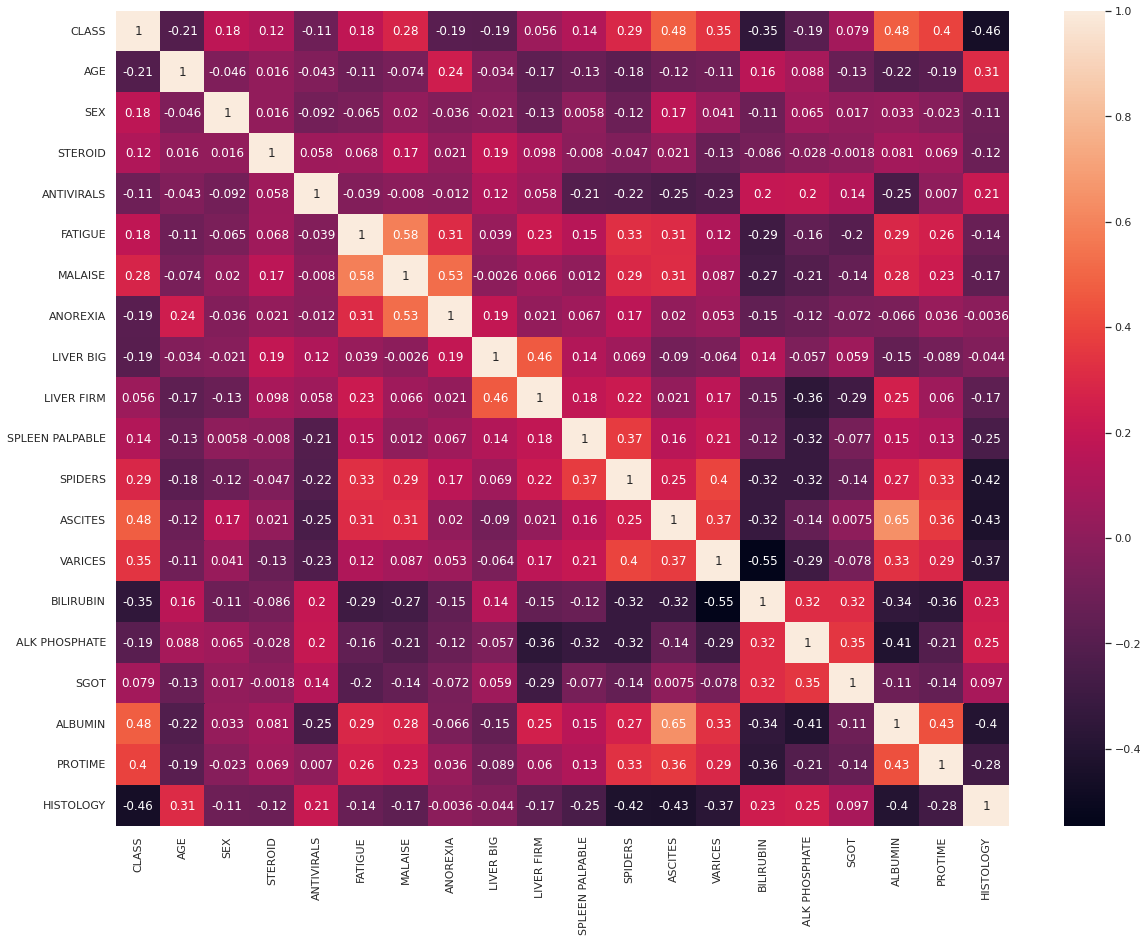

In [ ]:
# Correlation on heatmap
sns.set(rc={'figure.figsize':(20, 15)})
sns.heatmap(data_hepatitis.corr(), annot = True)

In [ ]:
# Go back to regular size graphs
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

We create two helper classes for our tests

In [ ]:
color_map = 'coolwarm'

def plot_test_and_train_data(x_train, y_train, x_test, y_test, x_feature, y_feature):
    plt.scatter(x_train[:,0], x_train[:,1], c=y_train, cmap=color_map, marker='o', label='train')
    plt.scatter(x_test[:,0], x_test[:,1], c=y_test, cmap=color_map, marker='s', label='test')
    plt.legend()
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.show()


class KNNTester:
    def __init__(self, model, x_train, y_train, x_test, y_test, feature1, feature2):
        self.model = model
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.feature1 = feature1
        self.feature2 = feature2

    def train(self):
        self.y_prob, self.knns = self.model.fit(self.x_train, self.y_train).predict(self.x_test)

    def get_accuracy(self):
        #To get hard predictions by choosing the class with the maximum probability
        self.y_pred = np.argmax(self.y_prob, axis=-1)
        accuracy = np.sum(self.y_pred == self.y_test)/self.y_test.shape[0]
        return accuracy*100

    def display_results(self):
        #boolean array to later slice the indexes of correct and incorrect predictions
        correct = self.y_test == self.y_pred
        incorrect = np.logical_not(correct)
        
        #visualation of the points
        plt.scatter(self.x_train[:,0], self.x_train[:,1], c=self.y_train, marker='o', cmap=color_map, alpha=.2, label='train')
        plt.scatter(self.x_test[correct,0], self.x_test[correct,1], marker='.', c=self.y_pred[correct], cmap=color_map, label='correct')
        plt.scatter(self.x_test[incorrect,0], self.x_test[incorrect,1], marker='x', c=self.y_test[incorrect], cmap=color_map, label='misclassified')
        
        #connect each node to k-nearest neighbours in the training set
        for i in range(self.x_test.shape[0]):
            for k in range(self.model.K):
                hor = self.x_test[i,0], self.x_train[self.knns[i,k],0]
                ver = self.x_test[i,1], self.x_train[self.knns[i,k],1]
                plt.plot(hor, ver, 'k-', alpha=.1)
        
        plt.xlabel(self.feature1)
        plt.ylabel(self.feature2)
        plt.legend()
        plt.show()

    def boundaries(self, x, y):
        #we can make the grid finer by increasing the number of samples from 200 to higher value
        x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
        x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)

        #to features values as a mesh  
        x0, x1 = np.meshgrid(x0v, x1v)
        x_all = np.vstack((x0.ravel(),x1.ravel())).T
        
        #y_train_prob = np.zeros((self.y_train.shape[0], self.model.C))
        y_train_prob = np.zeros((self.y_train.shape[0], self.model.C))
        y_train_prob[np.arange(self.y_train.shape[0]), self.y_train] = 1

        #to get class probability of all the points in the 2D grid
        y_prob_all, _ = self.model.fit(self.x_train, self.y_train).predict(x_all)

        y_pred_all = np.zeros_like(y_prob_all)
        y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1

        plt.scatter(self.x_train[:,0], self.x_train[:,1], c=y_train_prob, marker='o', alpha=1)
        plt.scatter(x_all[:,0], x_all[:,1], c=y_pred_all, marker='.', alpha=0.01)
        plt.ylabel(self.feature2)
        plt.xlabel(self.feature1)
        plt.show()

class DecisionTreeTester:
    def __init__(self, tree, x_train, y_train, x_test, y_test, feature1, feature2):
        self.tree = tree
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.feature1 = feature1
        self.feature2 = feature2

    def train(self):
        probs_test = self.tree.fit(self.x_train, self.y_train).predict(self.x_test)
        self.y_pred = np.argmax(probs_test,1)

    def get_accuracy(self):
        accuracy = np.sum(self.y_pred == self.y_test)/self.y_test.shape[0]
        return accuracy*100

    def display_results(self):
        #visualization
        correct = self.y_test == self.y_pred
        incorrect = np.logical_not(correct)

        plt.scatter(self.x_train[:,0], self.x_train[:,1], c=self.y_train, marker='o', cmap=color_map, alpha=.2, label='train')
        plt.scatter(self.x_test[correct,0], self.x_test[correct,1], marker='.', c=self.y_pred[correct], cmap=color_map, label='correct')
        plt.scatter(self.x_test[incorrect,0], self.x_test[incorrect,1], marker='x', c=self.y_test[incorrect], cmap=color_map, label='misclassified')
        plt.legend()
        plt.xlabel(self.feature1)
        plt.ylabel(self.feature2)
        plt.show()

    def boundaries(self, x, y):
        x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
        x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)
        x0,x1 = np.meshgrid(x0v, x1v)
        x_all = np.vstack((x0.ravel(),x1.ravel())).T

        y_train_prob = np.zeros((self.y_train.shape[0], self.tree.num_classes))
        y_train_prob[np.arange(self.y_train.shape[0]), self.y_train] = 1
        y_prob_all = self.tree.fit(self.x_train, self.y_train).predict(x_all)
        plt.scatter(self.x_train[:,0], self.x_train[:,1], c=y_train_prob, marker='o', cmap=color_map, alpha=1)
        plt.scatter(x_all[:,0], x_all[:,1], c=y_prob_all, marker='.', cmap=color_map, alpha=.01)
        plt.ylabel(self.feature2)
        plt.xlabel(self.feature1)
        plt.show()


Value of K and max depth

In [ ]:
k = 3
depth = 20

### Test#1

#### Data

instances (N) 	 80 
 features (D) 	 2 
 classes (C) 	 2


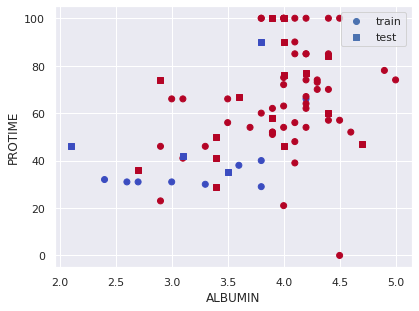

In [ ]:
# Use PROTIME and ALBUMIN
# PROTIME has a correlation of 0.40 with CLASS
# ALBUMIN has a correlation of 0.48 with CLASS
# Between themselves, they have a correlation of 0.43

y1 = data_hepatitis['CLASS'].to_numpy()
x1 = data_hepatitis[['ALBUMIN','PROTIME']].to_numpy()

(N,D), C = x1.shape, np.max(y1)
print(f'instances (N) \t {N} \n features (D) \t {D} \n classes (C) \t {C}')

inds = np.random.permutation(N)

x_train1, y_train1 = x1[inds[:60]], y1[inds[:60]]
x_test1, y_test1 = x1[inds[60:]], y1[inds[60:]]

plot_test_and_train_data(x_train1, y_train1, x_test1, y_test1, "ALBUMIN", "PROTIME")

#### KNN

accuracy: 75.0


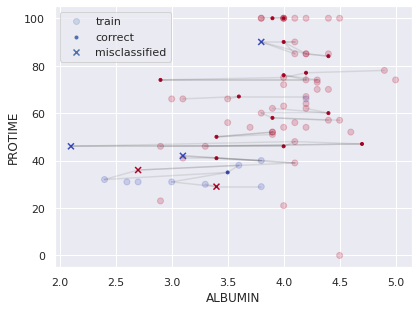

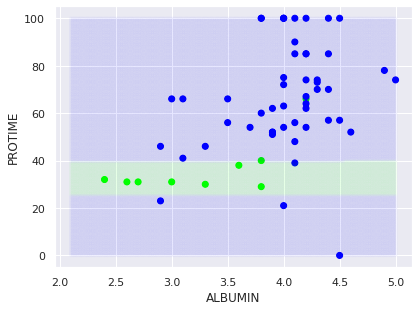

In [ ]:
model = KNN(K=k)
tester = KNNTester(model, x_train1, y_train1, x_test1, y_test1, 'ALBUMIN', 'PROTIME')

tester.train()
print(f'accuracy: {tester.get_accuracy()}')
tester.display_results()
print('\n')
tester.boundaries(x1,y1)

#### Decision Tree

accuracy: 75.0


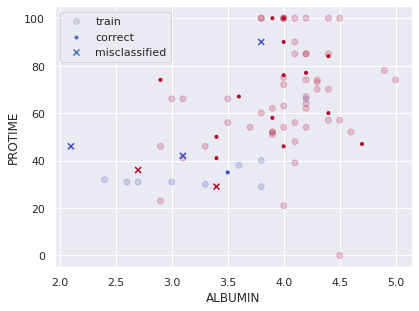

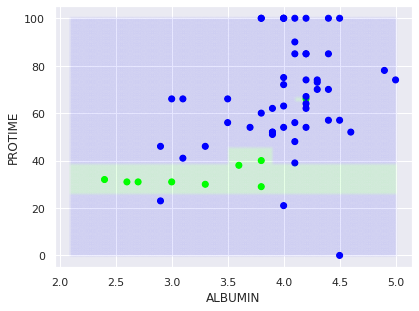

In [ ]:
tree = DecisionTree(max_depth=depth)
tester = DecisionTreeTester(tree, x_train1, y_train1, x_test1, y_test1, 'ALBUMIN', 'PROTIME')
tester.train()
print(f'accuracy: {tester.get_accuracy()}')
tester.display_results()
print('\n')
tester.boundaries(x1,y1)

### Test#2

#### Data

instances (N) 	 80 
 features (D) 	 2 
 classes (C) 	 2


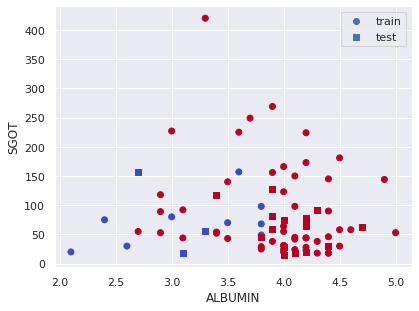

In [ ]:
# Use SGOT and ALBUMIN
# SGOT has a correlation of 0.079 with CLASS
# ALBUMIN has a correlation of 0.48 with CLASS
# Between themselves, they have a correlation of -0.11

y2 = data_hepatitis['CLASS'].to_numpy()
x2 = data_hepatitis[['ALBUMIN','SGOT']].to_numpy()

(N,D), C = x2.shape, np.max(y2)
print(f'instances (N) \t {N} \n features (D) \t {D} \n classes (C) \t {C}')

inds = np.random.permutation(N)

x_train2, y_train2 = x2[inds[:60]], y2[inds[:60]]
x_test2, y_test2 = x2[inds[60:]], y2[inds[60:]]

plot_test_and_train_data(x_train2, y_train2, x_test2, y_test2, 'ALBUMIN', 'SGOT')

#### KNN

accuracy: 60.0


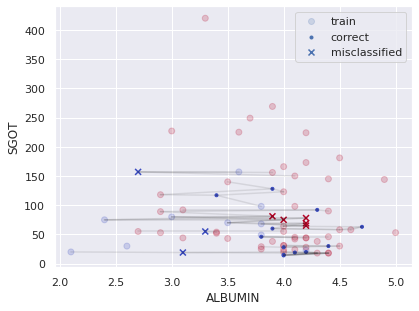

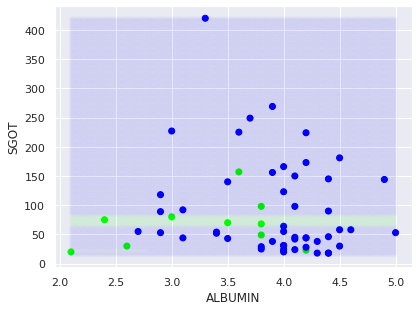

In [ ]:
#Edit K for different results
model = KNN(K=k)
tester = KNNTester(model, x_train2, y_train2, x_test2, y_test2, 'ALBUMIN', 'SGOT')

tester.train()
print(f'accuracy: {tester.get_accuracy()}')
tester.display_results()
print('\n')
tester.boundaries(x2,y2)

#### Decision Tree

accuracy: 70.0


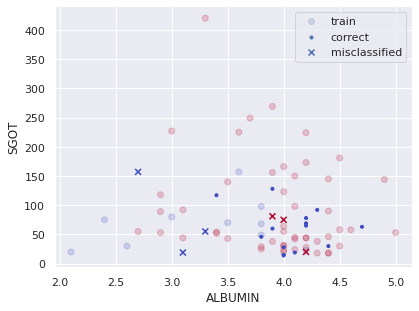

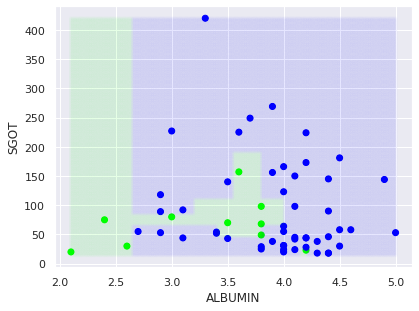

In [ ]:
tree = DecisionTree(max_depth=depth)

tester = DecisionTreeTester(tree, x_train2, y_train2, x_test2, y_test2, 'ALBUMIN', 'SGOT')
tester.train()
print(f'accuracy: {tester.get_accuracy()}')
tester.display_results()
print('\n')
tester.boundaries(x2,y2)

### Test#3

#### Data

instances (N) 	 80 
 features (D) 	 2 
 classes (C) 	 2


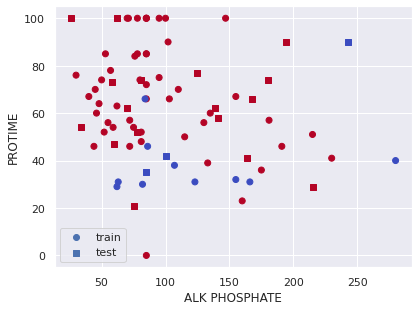

In [ ]:
# Use PROTIME and ALK PHOSPHATE
# PROTIME has a correlation of 0.40 with CLASS
# ALK PHOSPHATE has a correlation of -0.19 with CLASS
# Between themselves, they have a correlation of -0.21

y3 = data_hepatitis['CLASS'].to_numpy()
x3 = data_hepatitis[['ALK PHOSPHATE','PROTIME']].to_numpy()

(N,D), C = x3.shape, np.max(y3)
print(f'instances (N) \t {N} \n features (D) \t {D} \n classes (C) \t {C}')

inds = np.random.permutation(N)

x_train3, y_train3 = x3[inds[:60]], y3[inds[:60]]
x_test3, y_test3 = x3[inds[60:]], y3[inds[60:]]

plot_test_and_train_data(x_train3, y_train3, x_test3, y_test3, 'ALK PHOSPHATE', 'PROTIME')

#### KNN

accuracy: 85.0


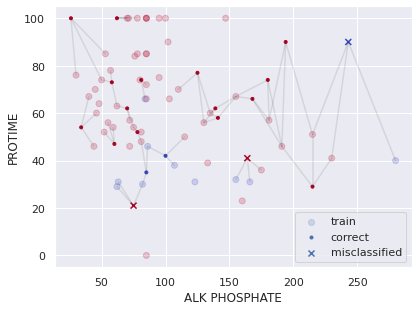

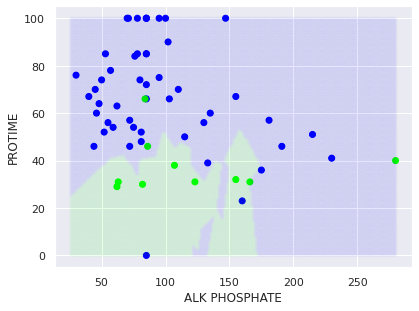

In [ ]:
model = KNN(K=k)
tester = KNNTester(model, x_train3, y_train3, x_test3, y_test3, 'ALK PHOSPHATE', 'PROTIME')

tester.train()
print(f'accuracy: {tester.get_accuracy()}')
tester.display_results()
print('\n')
tester.boundaries(x3,y3)

#### Decision Tree

accuracy: 90.0


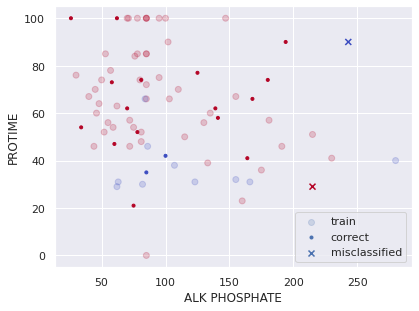

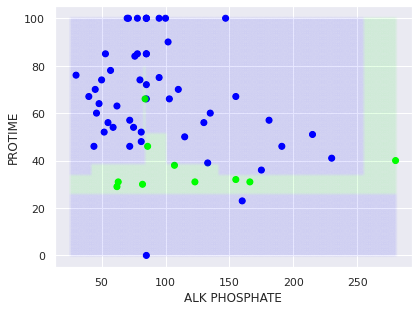

In [ ]:
tree = DecisionTree(max_depth=depth)

tester = DecisionTreeTester(tree, x_train3, y_train3, x_test3, y_test3, 'ALK PHOSPHATE', 'PROTIME')
tester.train()
print(f'accuracy: {tester.get_accuracy()}')
tester.display_results()
print('\n')
tester.boundaries(x3,y3)

### Test#4

#### Data

<class 'numpy.int64'>
(80, 2)
instances (N) 	 80 
 features (D) 	 2 
 classes (C) 	 2


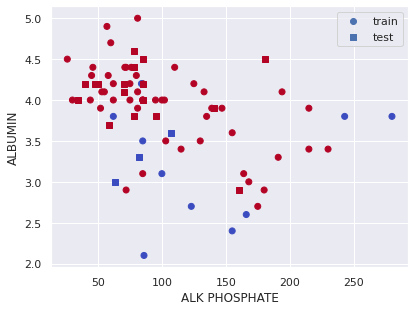

In [ ]:
# Use ALBUMIN and ALK PHOSPHATE
# ALBUMIN has a correlation of 0.48 with CLASS
# ALK PHOSPHATE has a correlation of -0.19 with CLASS
# Between themselves, they have a correlation of -0.41

y4 = data_hepatitis['CLASS'].to_numpy()
print(type(y4[0]))
x4 = data_hepatitis[['ALK PHOSPHATE','ALBUMIN']].to_numpy()
print(x4.shape)

(N,D), C = x4.shape, np.max(y4)
print(f'instances (N) \t {N} \n features (D) \t {D} \n classes (C) \t {C}')

inds = np.random.permutation(N)

x_train4, y_train4 = x4[inds[:60]], y4[inds[:60]]
x_test4, y_test4 = x4[inds[60:]], y4[inds[60:]]

plot_test_and_train_data(x_train4, y_train4, x_test4, y_test4, 'ALK PHOSPHATE', 'ALBUMIN')

#### KNN

accuracy: 85.0


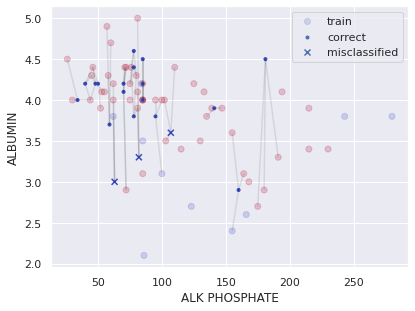

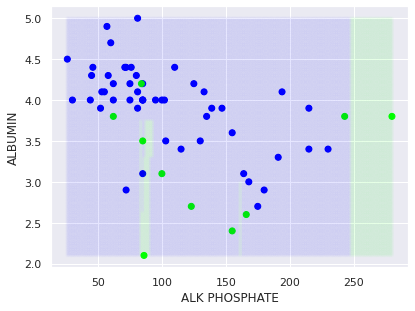

In [ ]:
model = KNN(K=k)
tester = KNNTester(model, x_train4, y_train4, x_test4, y_test4, 'ALK PHOSPHATE', 'ALBUMIN')

tester.train()
print(f'accuracy: {tester.get_accuracy()}')
tester.display_results()
print('\n')
tester.boundaries(x4,y4)

#### Decision Tree

accuracy: 85.0


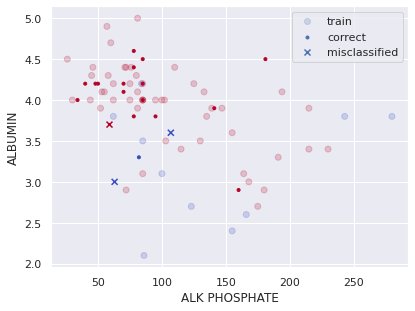

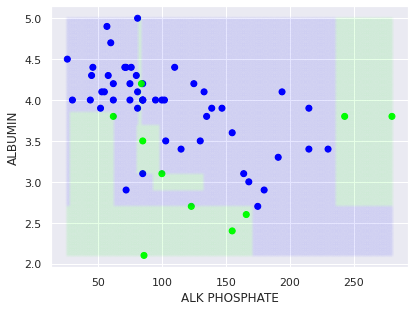

In [ ]:
tree = DecisionTree(max_depth=depth)

tester = DecisionTreeTester(tree, x_train4, y_train4, x_test4, y_test4, 'ALK PHOSPHATE', 'ALBUMIN')
tester.train()
print(f'accuracy: {tester.get_accuracy()}')
tester.display_results()
print('\n')
tester.boundaries(x4,y4)

### Comparing K and max_depth values

We first create two methods to easily execute these tests

In [ ]:
def test_K_values(dataset, feature1, feature2, target, data_separator, num_K):
    y = dataset[target].to_numpy()
    x = dataset[[feature1, feature2]].to_numpy()

    (N,D), C = x.shape, np.max(y)

    inds = np.random.permutation(N)

    x_train, y_train = x[inds[:data_separator]], y[inds[:data_separator]]
    x_test, y_test = x[inds[data_separator:]], y[inds[data_separator:]]

    k_values = []
    accuracies = []
    for i in range(1, num_K):
        model = KNN(K=i)
        tester = KNNTester(model, x_train, y_train, x_test, y_test, feature1, feature2)
        tester.train()
        accuracy = tester.get_accuracy()
        k_values.append(i)
        accuracies.append(accuracy)
    

    plt.scatter(k_values, accuracies)
    plt.plot(k_values, accuracies)
    plt.ylabel("Accuracy")
    plt.xlabel("K Value")
    plt.title("Compare K values")
    plt.show()

def test_depth_values(dataset, feature1, feature2, target, data_separator, num_depth):
    y = dataset[target].to_numpy()
    x = dataset[[feature1, feature2]].to_numpy()

    (N,D), C = x.shape, np.max(y)

    inds = np.random.permutation(N)

    x_train, y_train = x[inds[:data_separator]], y[inds[:data_separator]]
    x_test, y_test = x[inds[data_separator:]], y[inds[data_separator:]]

    depth_values = []
    accuracies = []
    for i in range(1, num_depth):
        tree = DecisionTree(max_depth=i)
        tester = DecisionTreeTester(tree, x_train, y_train, x_test, y_test, feature1, feature2)
        tester.train()
        accuracy = tester.get_accuracy()
        depth_values.append(i)
        accuracies.append(accuracy)

    plt.scatter(depth_values, accuracies)
    plt.plot(depth_values, accuracies)
    plt.ylabel("Accuracy")
    plt.xlabel("Depth Value")
    plt.title("Compare max_depth values")
    plt.show()


We pick the <strong>ALK PHOSPHATE</strong> and <strong>ALBUMIN</strong> pair, as it seems to result in a high accuracy. We test this pair with different K values.

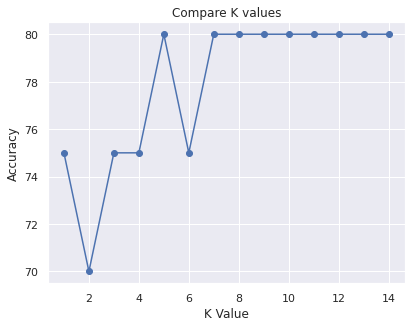

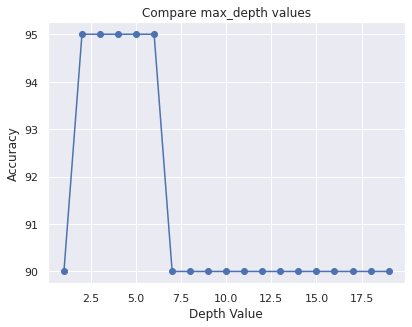

In [ ]:
test_K_values(data_hepatitis, 'ALK PHOSPHATE', 'ALBUMIN', 'CLASS', 60, 15)
print()
test_depth_values(data_hepatitis, 'ALK PHOSPHATE', 'ALBUMIN', 'CLASS', 60, 20)

### Comparing distance and cost functions

We first create two helper functions.

In [ ]:
def test_distance_functions(dataset, feature1, feature2, target, data_separator, k_value, num_runs):
    euclidean_accuracies = []
    manhattan_accuracies = []
    for i in range(num_runs):
        y = dataset[target].to_numpy()
        x = dataset[[feature1, feature2]].to_numpy()
    
        (N,D), C = x.shape, np.max(y)
    
        inds = np.random.permutation(N)
    
        x_train, y_train = x[inds[:data_separator]], y[inds[:data_separator]]
        x_test, y_test = x[inds[data_separator:]], y[inds[data_separator:]]
    
        # KNN with euclidean
        model = KNN(K=k_value, dist_fn=euclidean)
        tester = KNNTester(model, x_train, y_train, x_test, y_test, feature1, feature2)
        tester.train()
        accuracy = tester.get_accuracy()
        euclidean_accuracies.append(accuracy)

        # KNN with manhattan
        model = KNN(K=k_value, dist_fn=manhattan)
        tester = KNNTester(model, x_train, y_train, x_test, y_test, feature1, feature2)
        tester.train()
        accuracy = tester.get_accuracy()
        manhattan_accuracies.append(accuracy)

    print(f"After {num_runs} runs, we have the following average results for distance functions:")
    print(f"Euclidean: Accuracy = {sum(euclidean_accuracies) / len(euclidean_accuracies)}")
    print(f"Manhattan: Accuracy = {sum(manhattan_accuracies) / len(manhattan_accuracies)}")

def test_cost_functions(dataset, feature1, feature2, target, data_separator, depth, num_runs):
    misclassification_accuracies = []
    entropy_accuracies = []
    gini_accuracies = []
    for i in range(num_runs):
        y = dataset[target].to_numpy()
        x = dataset[[feature1, feature2]].to_numpy()
    
        (N,D), C = x.shape, np.max(y)
    
        inds = np.random.permutation(N)
    
        x_train, y_train = x[inds[:data_separator]], y[inds[:data_separator]]
        x_test, y_test = x[inds[data_separator:]], y[inds[data_separator:]]
    
        # Decision tree with cost misclassification function
        tree = DecisionTree(max_depth=depth, cost_fn=cost_misclassification)
        tester = DecisionTreeTester(tree, x_train, y_train, x_test, y_test, feature1, feature2)
        tester.train()
        accuracy = tester.get_accuracy()
        misclassification_accuracies.append(accuracy)
    
        # Decision tree with cost entropy function
        tree = DecisionTree(max_depth=depth, cost_fn=cost_entropy)
        tester = DecisionTreeTester(tree, x_train, y_train, x_test, y_test, feature1, feature2)
        tester.train()
        accuracy = tester.get_accuracy()
        entropy_accuracies.append(accuracy)    

        # Decision tree with cost gini index
        tree = DecisionTree(max_depth=depth, cost_fn=cost_gini_index)
        tester = DecisionTreeTester(tree, x_train, y_train, x_test, y_test, feature1, feature2)
        tester.train()
        accuracy = tester.get_accuracy()
        gini_accuracies.append(accuracy)

    print(f"After {num_runs} runs, we have the following average results for cost functions:")
    print(f"Misclassification cost: Accuracy = {sum(misclassification_accuracies) / len(misclassification_accuracies)}")
    print(f"Entropy cost: Accuracy = {sum(entropy_accuracies) / len(entropy_accuracies)}")
    print(f"Gini cost: Accuracy = {sum(gini_accuracies) / len(gini_accuracies)}")


We use the features <strong>ALK PHOSPHATE</strong> and <strong>ALBUMIN</strong> as they seem to result in a high accuracy. We test the different distance and cost functions.

In [ ]:
test_distance_functions(data_hepatitis, 'ALK PHOSPHATE', 'ALBUMIN', 'CLASS', 60, 6, 10)
print()
test_cost_functions(data_hepatitis, 'ALK PHOSPHATE', 'ALBUMIN', 'CLASS', 60, 6, 10)

After 10 runs, we have the following average results for distance functions:
Euclidean: Accuracy = 83.0
Manhattan: Accuracy = 83.0

After 10 runs, we have the following average results for cost functions:
Misclassification cost: Accuracy = 82.5
Entropy cost: Accuracy = 79.5
Gini cost: Accuracy = 80.0


## KNN and Decision Tree on diabetic data set

Once again, we use the correlation heatmap for our feature selection.

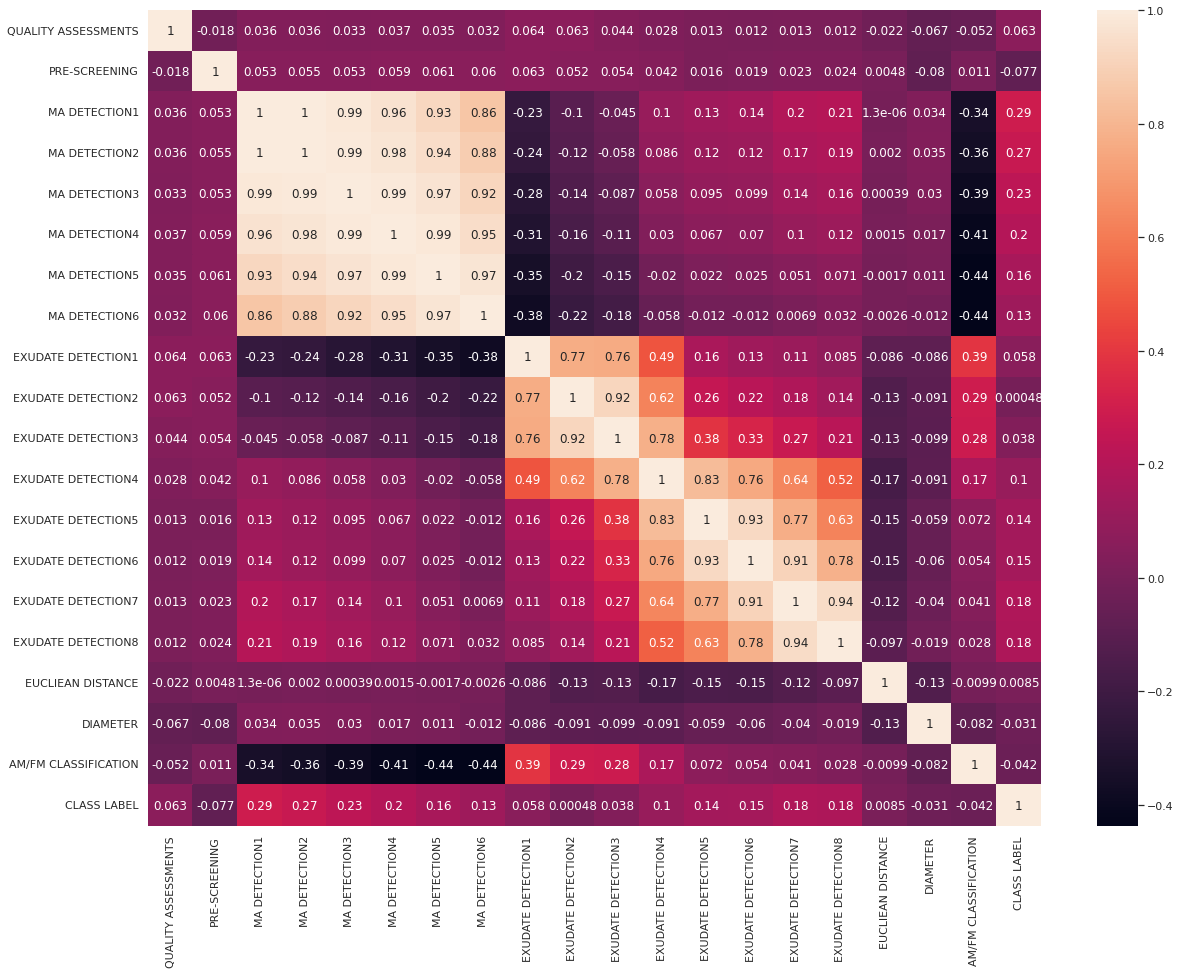

In [ ]:
# Correlation on heatmap
sns.set(rc={'figure.figsize':(20, 15)})
sns.heatmap(data_diabetic.corr(), annot = True)

In [ ]:
# Go back to regular size graphs
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

### Test#1

#### Data

instances (N) 	 1151 
 features (D) 	 2 
 classes (C) 	 2


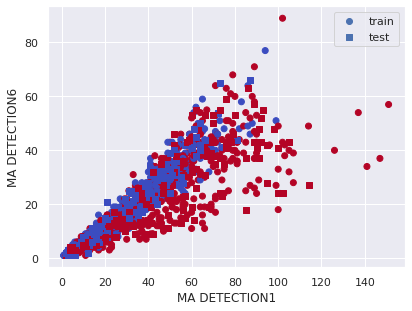

In [ ]:
# Use MA DETECTION1 and MA DETECTION6
# MA DETECTION1 has a correlation of 0.29 with CLASS LABEL
# MA DETECTION6 has a correlation of 0.13 with CLASS LABEL
# Between themselves, they have a correlation of 0.86

y5 = data_diabetic['CLASS LABEL'].to_numpy()
x5 = data_diabetic[['MA DETECTION1','MA DETECTION6']].to_numpy()

(N,D), C = x5.shape, np.max(y5)
print(f'instances (N) \t {N} \n features (D) \t {D} \n classes (C) \t {C}')

inds = np.random.permutation(N)

x_train5, y_train5 = x5[inds[:863]], y5[inds[:863]]
x_test5, y_test5 = x5[inds[863:]], y5[inds[863:]]

plot_test_and_train_data(x_train5, y_train5, x_test5, y_test5, "MA DETECTION1", "MA DETECTION6")

#### KNN

accuracy: 58.68055555555556


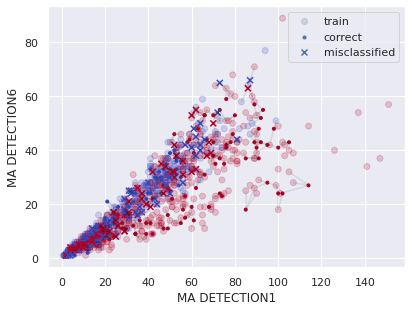

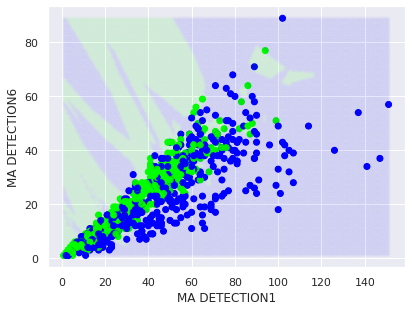

In [ ]:
model = KNN(K=k)
tester = KNNTester(model, x_train5, y_train5, x_test5, y_test5, 'MA DETECTION1', 'MA DETECTION6')

tester.train()
print(f'accuracy: {tester.get_accuracy()}')
tester.display_results()
print('\n')
tester.boundaries(x5, y5)

#### Decision Tree

accuracy: 59.375


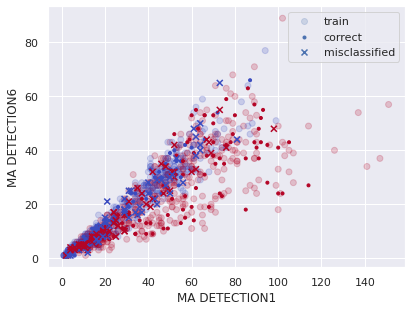

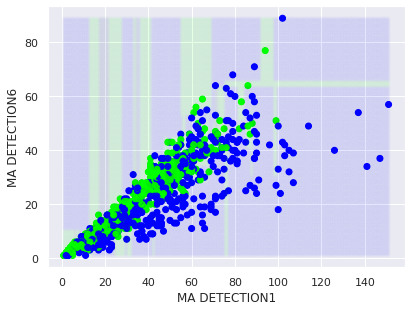

In [ ]:
tree = DecisionTree(max_depth=depth)

tester = DecisionTreeTester(tree, x_train5, y_train5, x_test5, y_test5, 'MA DETECTION1', 'MA DETECTION6')
tester.train()
print(f'accuracy: {tester.get_accuracy()}')
tester.display_results()
print('\n')
tester.boundaries(x5,y5)

### Test#2

#### Data

instances (N) 	 1151 
 features (D) 	 2 
 classes (C) 	 2


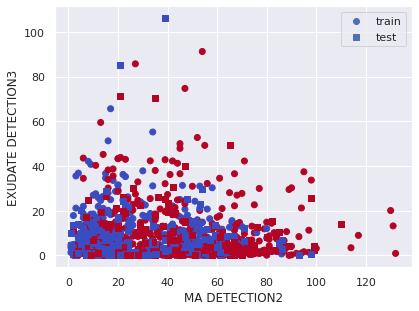

In [ ]:
# Use MA DETECTION2 and EXUDATE DETECTION3
# MA DETECTION2 has a correlation of 0.27 with CLASS LABEL
# EXUDATE DETECTION3 has a correlation of 0.038 with CLASS LABEL
# Between themselves, they have a correlation of -0.058

y6 = data_diabetic['CLASS LABEL'].to_numpy()
x6 = data_diabetic[['MA DETECTION2','EXUDATE DETECTION3']].to_numpy()

(N,D), C = x5.shape, np.max(y6)
print(f'instances (N) \t {N} \n features (D) \t {D} \n classes (C) \t {C}')

inds = np.random.permutation(N)

x_train6, y_train6 = x6[inds[:863]], y6[inds[:863]]
x_test6, y_test6 = x6[inds[863:]], y6[inds[863:]]

plot_test_and_train_data(x_train6, y_train6, x_test6, y_test6, "MA DETECTION2", "EXUDATE DETECTION3")

#### KNN

accuracy: 55.55555555555556


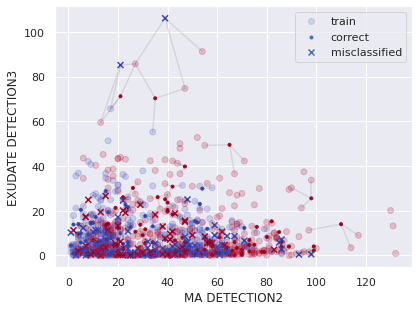

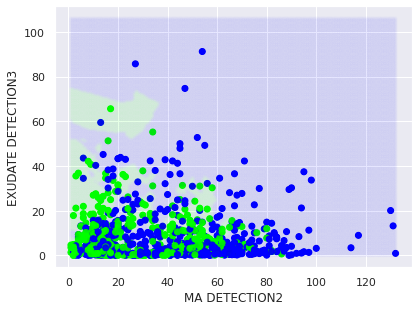

In [ ]:
model = KNN(K=k)
tester = KNNTester(model, x_train6, y_train6, x_test6, y_test6, 'MA DETECTION2', 'EXUDATE DETECTION3')

tester.train()
print(f'accuracy: {tester.get_accuracy()}')
tester.display_results()
print('\n')
tester.boundaries(x6, y6)

#### Decision Tree

accuracy: 52.77777777777778


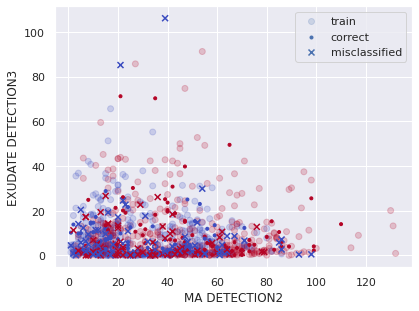

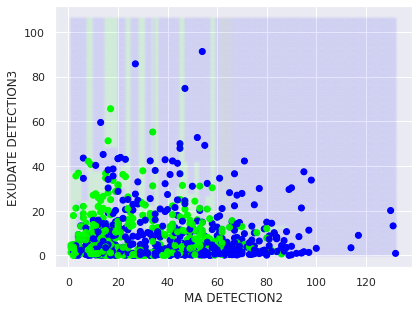

In [ ]:
tree = DecisionTree(max_depth=depth)

tester = DecisionTreeTester(tree, x_train6, y_train6, x_test6, y_test6, 'MA DETECTION2', 'EXUDATE DETECTION3')
tester.train()
print(f'accuracy: {tester.get_accuracy()}')
tester.display_results()
print('\n')
tester.boundaries(x6,y6)

### Test#3

#### Data

instances (N) 	 1151 
 features (D) 	 2 
 classes (C) 	 2


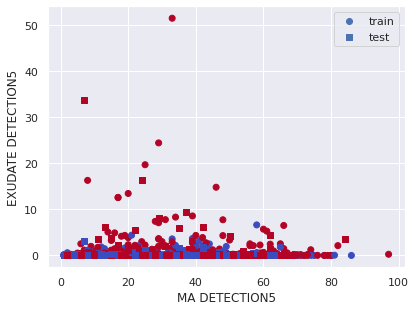

In [ ]:
# Use EXUDATE DETECTION5 and MA DETECTION5
# EXUDATE DETECTION5 has a correlation of 0.14 with CLASS LABEL
# MA DETECTION5 has a correlation of 0.16 with CLASS LABEL
# Between themselves, they have a correlation of 0.022

y7 = data_diabetic['CLASS LABEL'].to_numpy()
x7 = data_diabetic[['MA DETECTION5','EXUDATE DETECTION5']].to_numpy()

(N,D), C = x5.shape, np.max(y6)
print(f'instances (N) \t {N} \n features (D) \t {D} \n classes (C) \t {C}')

inds = np.random.permutation(N)

x_train7, y_train7 = x7[inds[:863]], y7[inds[:863]]
x_test7, y_test7 = x7[inds[863:]], y7[inds[863:]]

plot_test_and_train_data(x_train7, y_train7, x_test7, y_test7, "MA DETECTION5", "EXUDATE DETECTION5")

#### KNN

accuracy: 56.94444444444444


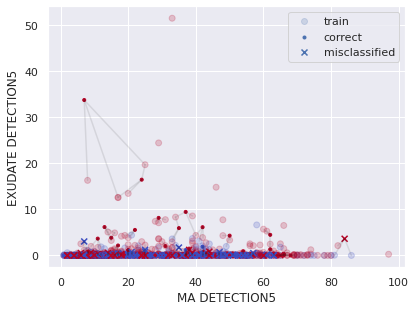

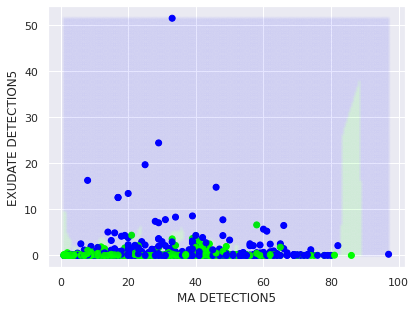

In [ ]:
model = KNN(K=k)
tester = KNNTester(model, x_train7, y_train7, x_test7, y_test7, 'MA DETECTION5', 'EXUDATE DETECTION5')

tester.train()
print(f'accuracy: {tester.get_accuracy()}')
tester.display_results()
print('\n')
tester.boundaries(x7, y7)

#### Decision Tree

accuracy: 54.513888888888886


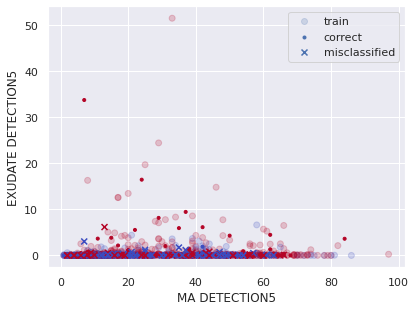

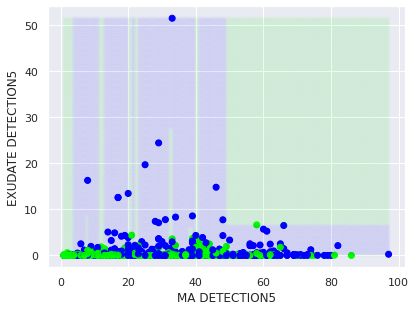

In [ ]:
tree = DecisionTree(max_depth=depth)

tester = DecisionTreeTester(tree, x_train7, y_train7, x_test7, y_test7, 'MA DETECTION5', 'EXUDATE DETECTION5')
tester.train()
print(f'accuracy: {tester.get_accuracy()}')
tester.display_results()
print('\n')
tester.boundaries(x7,y7)

### Test#4

#### Data

instances (N) 	 1151 
 features (D) 	 2 
 classes (C) 	 2


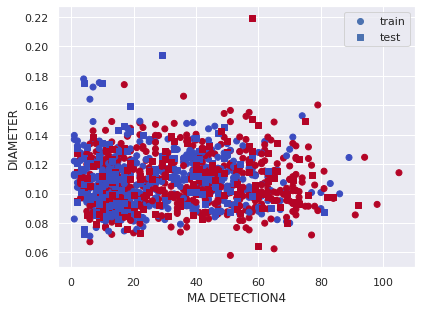

In [ ]:
# Use DIAMETER and MA DETECTION4
# DIAMETER has a correlation of -0.031 with CLASS LABEL
# MA DETECTION4 has a correlation of 0.20 with CLASS LABEL
# Between themselves, they have a correlation of 0.017

y8 = data_diabetic['CLASS LABEL'].to_numpy()
x8 = data_diabetic[['MA DETECTION4','DIAMETER']].to_numpy()

(N,D), C = x8.shape, np.max(y8)
print(f'instances (N) \t {N} \n features (D) \t {D} \n classes (C) \t {C}')

inds = np.random.permutation(N)

x_train8, y_train8 = x8[inds[:863]], y8[inds[:863]]
x_test8, y_test8 = x8[inds[863:]], y8[inds[863:]]

plot_test_and_train_data(x_train8, y_train8, x_test8, y_test8, "MA DETECTION4", "DIAMETER")

#### KNN

accuracy: 56.59722222222222


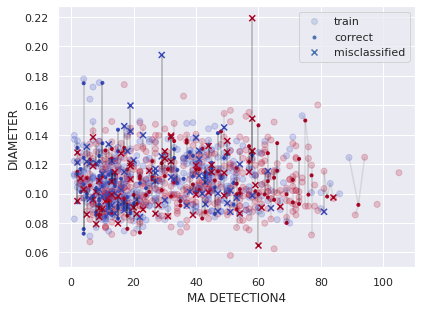

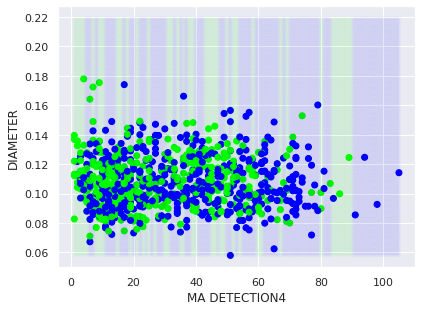

In [ ]:
model = KNN(K=k)
tester = KNNTester(model, x_train8, y_train8, x_test8, y_test8, 'MA DETECTION4', 'DIAMETER')

tester.train()
print(f'accuracy: {tester.get_accuracy()}')
tester.display_results()
print('\n')
tester.boundaries(x8, y8)

#### Decision Tree

accuracy: 57.638888888888886


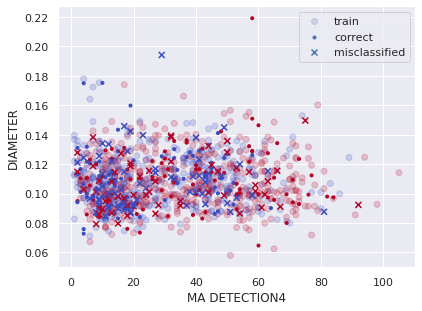

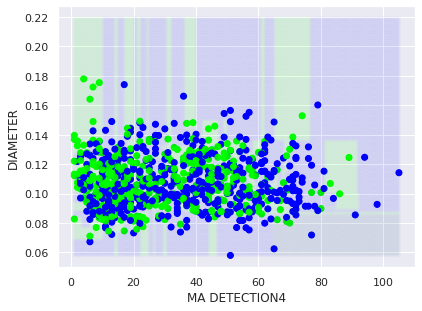

In [ ]:
tree = DecisionTree(max_depth=depth)

tester = DecisionTreeTester(tree, x_train8, y_train8, x_test8, y_test8, 'MA DETECTION4', 'DIAMETER')
tester.train()
print(f'accuracy: {tester.get_accuracy()}')
tester.display_results()
print('\n')
tester.boundaries(x8,y8)

### Comparing K and max_depth values

We will use the <strong>MA DETECTION1</strong> and <strong>MA DETECTION6</strong>, as the pair seems to result in a high accuracy.

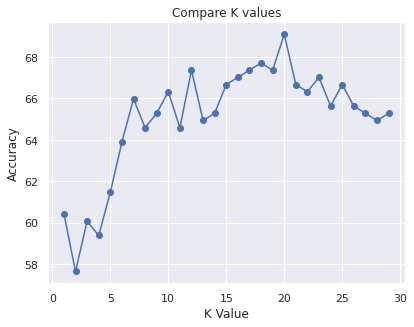

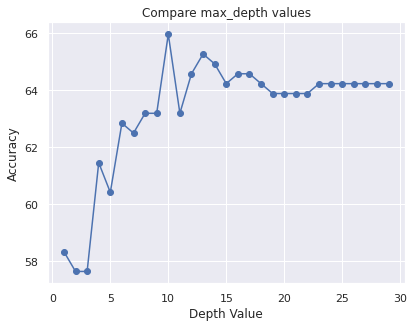

In [ ]:
test_K_values(data_diabetic, 'MA DETECTION1', 'MA DETECTION6', 'CLASS LABEL', 863, 30)
print()
test_depth_values(data_diabetic, 'MA DETECTION1', 'MA DETECTION6', 'CLASS LABEL', 863, 30)

### Comparing distance and cost functions

We will use the <strong>MA DETECTION1</strong> and <strong>MA DETECTION6</strong> features, as the pair seems to result in a high accuracy.

In [ ]:
test_distance_functions(data_diabetic, 'MA DETECTION1', 'MA DETECTION6', 'CLASS LABEL', 863, 15, 10)
print()
test_cost_functions(data_diabetic, 'MA DETECTION1', 'MA DETECTION6', 'CLASS LABEL', 863, 7, 10)

After 10 runs, we have the following average results for distance functions:
Euclidean: Accuracy = 67.46527777777779
Manhattan: Accuracy = 67.25694444444446

After 10 runs, we have the following average results for cost functions:
Misclassification cost: Accuracy = 63.33333333333333
Entropy cost: Accuracy = 64.02777777777779
Gini cost: Accuracy = 64.86111111111111
